In [1]:
import pyvisa
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.vna import VNA
from nanodrivers.visa_drivers.signal_analyser import Anri
# from nanodrivers.visa_drivers.signal_analizar import Anri

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize

#file_store
import os

#time
import time
from datetime import datetime, timedelta

from ctypes import *
%matplotlib inline

Global_data_adress = r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA"
exp_name = 'TWPA_noise_3'
adress = Global_data_adress+'\\'+exp_name
if not os.path.exists(adress):
  os.mkdir(adress)
  print("Folder %s created!" % adress)
else:
  print("Folder %s already exists" % adress)

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_3 already exists


In [2]:
path = adress +'\\'+ '1st_tone'
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  print("Folder %s already exists" % path)

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_3\1st_tone already exists


In [7]:
anapico = ANAPICO()
anapico.idn()
anapico.dump()['channel_status']

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,0.4.209



array([0., 0., 0., 0.])

In [3]:
dc = DC()
dc.idn()
dc.dump()

VisaIOError: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).

In [5]:
vna = VNA()
vna.idn()
# vna.dump()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



# Check if TWPA works

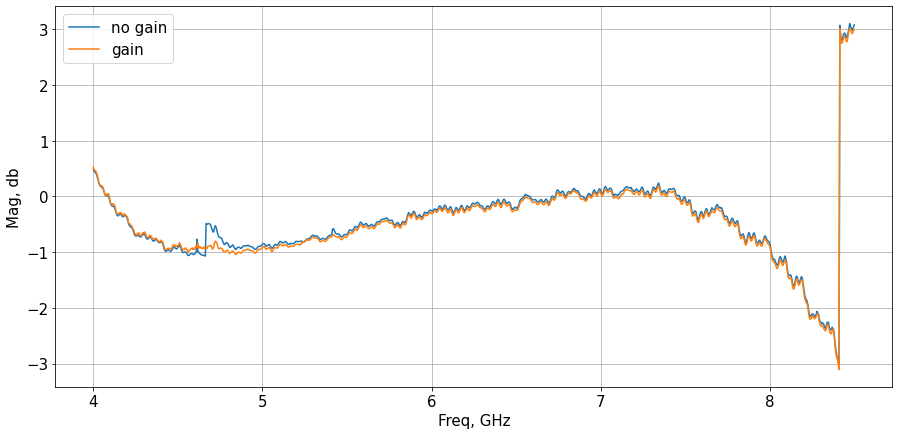

In [50]:
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize = (15, 7))
ax.grid()
ax.set_xlabel('Freq, GHz')
ax.set_ylabel('Mag, db')

anapico.set_off(1)
dc.set_volt(0)

vna.set_band(1000)
vna.set_nop(1000)
vna.set_power(-10)
vna.set_freq_start_stop(4e9, 8.5e9, vna.get_nop())
mag, pha, freq = vna.get_data(True)
ax.plot(freq/1e9, pha, label = 'no gain')


# anapico.set_on(1)
dc.set_volt(1)
time.sleep(60)
mag, pha, freq = vna.get_data(True)
ax.plot(freq/1e9, pha, label = 'gain')
ax.legend()

In [64]:
dc.set_volt(0)

# Find elength

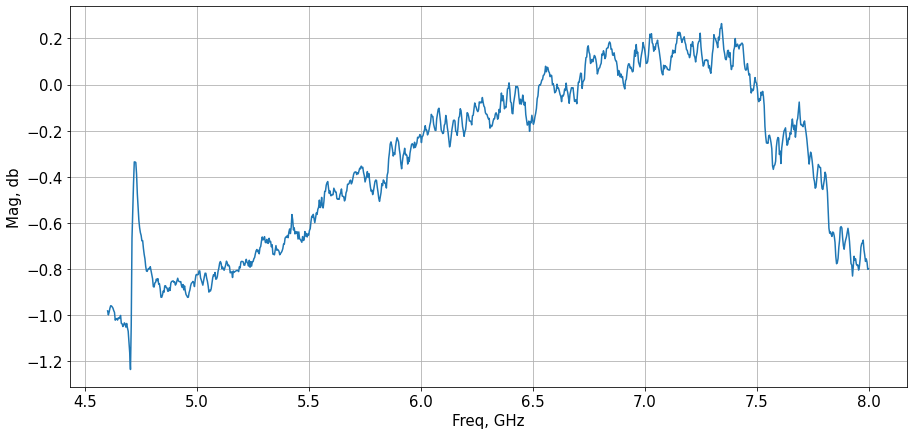

In [48]:
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize = (15, 7))
ax.grid()
ax.set_xlabel('Freq, GHz')
ax.set_ylabel('Mag, db')

anapico.set_off(1)
dc.set_volt(0)

vna.set_band(1000)
vna.set_nop(1000)
vna.set_power(-20)
vna.set_elength(12.32)
vna.set_lin()
vna.set_freq_start_stop(4.6e9, 8e9, vna.get_nop())

freq = vna.get_freq()
mag, pha = vna.get_data()
ax.plot(freq/1e9, pha, label = 'no gain')

# 1st tone

In [63]:
# %matplotlib qt
from IPython.display import display, clear_output
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(25,13))

volts = np.linspace(0, 2, 51)
vna.set_band(1000)
vna.set_nop(1001)
vna.set_lin()
vna.set_freq_start_stop(4e9, 8.5e9, vna.get_nop())

freqs = vna.get_freq()

state = dict()
state['freqs'] = freqs
state['volts'] = volts
state['vna'] = vna.dump
state['DC_dev'] = dc.dump
anapico.set_off(1)
state['anapico'] = anapico.dump()
state['temp'] = 9.64


mag_1t = np.ones((len(volts),len(freqs)))*(-40)
pha_1t = np.ones((len(volts),len(freqs)))*(0)

state['mag'] = mag_1t
state['pha'] = pha_1t

start_time = datetime.now()
file = r'1st_tone_no_AC_BigCap'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file

start_time = datetime.now()                  
for i in range(len(volts)+1):
    
    start_time = datetime.now()
    print('New round {}/{} ({} V) started at {}'.format(i, len(volts), volts[i], start_time.strftime(r'%H:%M:%S')))
        
        
    
#     time.sleep(500)
                  
    mag_1t[i], pha_1t[i] = vna.get_data()
    
    state['mag'] = mag_1t
    state['pha'] = pha_1t
    
    savemat(file_name, state)
    ax[0].cla()
    c = ax[0].pcolor(volts, freqs/1e9,  np.transpose(mag_1t), cmap='viridis')
    ax[0].set_xlabel(r'Bias, V')
    ax[0].set_ylabel(r'Probe frequency, GHz')
    
    ax[1].cla()
    c1 = ax[1].pcolor(volts, freqs/1e9,  np.transpose(pha_1t), cmap='viridis')
    ax[1].set_xlabel(r'Bias, V')
    ax[1].set_ylabel(r'Probe frequency, GHz')
    
    plt.savefig(path +'\\' + "1st_tone.png", dpi=150)

    if i == 0: 
        ax[0].set_title(r'$|S_{21}|$')
        ax[1].set_title(r'$\angle S_{21} $')
        fig.colorbar(c, ax=ax[0])
        fig.colorbar(c1, ax=ax[1])
        duration_end = datetime.now()
        period = (duration_end-start_time).seconds
        
        print('Duration: {}. End of script in: {}'.format(duration_end - start_time, 
                                        timedelta(seconds=period*len(volts))))
    
    display(fig)
    clear_output(wait = True)
    if i<len(volts):
        dc.set_volt(volts[i+1]) # you can just return it to previous version
        plt.pause(15)
    else: 
        pass
    
    
dc.set_volt(0)   
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

IndexError: index 51 is out of bounds for axis 0 with size 51

In [20]:
(21+100)*20/60/60

0.6722222222222223

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(25,13))

c = ax[0].pcolor(volts, freqs/1e9,  np.transpose(mag_1t-mag_1t[0]), cmap='viridis')
ax[0].set_xlabel(r'Bias, V')
ax[0].set_ylabel(r'Probe frequency, GHz')

c1 = ax[1].pcolor(volts, freqs/1e9,  np.transpose(np.unwrap(pha_1t)-np.unwrap(pha_1t)[0]), cmap='viridis')
ax[1].set_xlabel(r'Bias, V')
ax[1].set_ylabel(r'Probe frequency, GHz')

Text(0, 0.5, 'Probe frequency, GHz')

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(25,13))

c = ax[0].pcolor(volts, freqs/1e9,  np.transpose(mag_1t-mag_1t[0]), cmap='viridis')
ax[0].set_xlabel(r'Bias, V')
ax[0].set_ylabel(r'Probe frequency, GHz')

c1 = ax[1].pcolor(volts, freqs/1e9,  np.transpose(np.unwrap(pha_1t)), cmap='viridis')
ax[1].set_xlabel(r'Bias, V')
ax[1].set_ylabel(r'Probe frequency, GHz')

fig.colorbar(c, ax=ax[0])
fig.colorbar(c1, ax=ax[1])

# testing the TWPA heating

In [130]:
dc.set_volt(0)
pha_c = np.array([])
time_c = np.array([])

vna.set_cw_freq(5e9)
vna.set_nop(1000)
vna.set_power(-10)
vna.set_band(1000)

start_time = datetime.now()
vna.set_on()
time_run = vna.get_sweep_time()


vna.write("INIT1:IMM")
time.sleep(0.2 + time_run)
data_str = vna.query("CALC1:DATA? SDAT")
data = np.array(data_str.rstrip().split(",")).astype("float64")
s = data[0::2] + 1j * data[1::2]

ini_pha = angle(s)

dc_arr = np.linspace(0, 6, 40)

for i in range(len(dc_arr)):
    
    dc.set_volt(dc_arr[i])

    vna.write("INIT1:IMM")
    time.sleep(0.2 + time_run)
    data_str = vna.query("CALC1:DATA? SDAT")
    data = np.array(data_str.rstrip().split(",")).astype("float64")
    s = data[0::2] + 1j * data[1::2]

    c_time = datetime.now()
    time_c = np.append(time_c, (c_time-start_time).seconds)
    
    pha_c = np.append(pha_c, angle(s))
    
    
    dc.set_volt(0)

    
    vna.write("INIT1:IMM")
    time.sleep(0.2 + time_run)
    data_str = vna.query("CALC1:DATA? SDAT")
    data = np.array(data_str.rstrip().split(",")).astype("float64")
    s = data[0::2] + 1j * data[1::2]

    c_time = datetime.now()
    time_c = np.append(time_c, (c_time-start_time).seconds)
    
    pha_c = np.append(pha_c, angle(s))

KeyboardInterrupt: 

In [131]:
dc.set_volt(0)

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(25,13))
ax.plot(np.arange(len(pha_c))/1000, pha_c, '1')
# ax.axhline(y=ini_pha, color='r', linestyle='-')

In [93]:
pha_c

array([-0.91352726, -0.91598619, -0.91037009, ..., -0.91098251,
       -0.91259264, -0.91618936])

In [98]:
vna.get_band()

1000.0